# Linear Regression

We will follow the example given by [scikit-learn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html), and use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset to train and test a linear regressor. We begin by loading the dataset (using only two features for this example) and splitting it into training and testing samples (an 80/20 split).

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

dataset = datasets.load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(dataset.data[:, :2], dataset.target, test_size=0.2)
print("Train examples: %d, Test examples: %d" % (X_train.shape[0], X_test.shape[0]))

Train examples: 353, Test examples: 89


# Non-private baseline

We now use scikit-learn's native LinearRegression function to establish a non-private baseline for our experiments. We will use the [r-squared score](https://en.wikipedia.org/wiki/Coefficient_of_determination) to evaluate the goodness-of-fit of the model, which is built into LinearRegression. 

In [5]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

regr = sk_LinearRegression()
regr.fit(X_train, y_train)
baseline = regr.score(X_test, y_test)
print("Non-private baseline R2 score: %.2f" % baseline)

Non-private baseline R2 score: 0.03


# Differentially private Linear Regression

Let's now train a differentially private linear regressor, where the trained model is differentially private with respect to the training data. We will pass additional hyperparameters to the regressor later to suppress the `PrivacyLeakWarning`.

In [6]:
from diffprivlib.models import LinearRegression

regr = LinearRegression()
regr.fit(X_train, y_train)

print("R2 score for epsilon=%.2f: %.2f" % (regr.epsilon, regr.score(X_test, y_test)))

R2 score for epsilon=1.00: -0.09


/Users/najahkhalifa/venv/lib/python3.9/site-packages/diffprivlib/models/linear_regression.py:271: PrivacyLeakWarning: Bounds parameters haven't been specified, so falling back to determining bounds from the data.
This will result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `bounds_X` and `bounds_y`.
  warnings.warn(


# Plotting r-squared versus epsilon

We want to evaluate the tradeoff between goodness-of-fit and privacy budget (epsilon), and plot the result using `matplotlib`. For this example, we evaluate the score for epsilon between 1e-2 and 1e2. To ensure no privacy leakage from the hyperparameters of the model, `data_norm`, `range_X` and `range_y` should all be set independently of the data, i.e. using domain knowledge. 

In [7]:
import numpy as np

epsilons = np.logspace(-1, 2, 100)
accuracy = []

for epsilon in epsilons:
    regr = LinearRegression(epsilon=epsilon, bounds_X=(-0.138, 0.2), bounds_y=(25, 346))
    regr.fit(X_train, y_train)
    
    accuracy.append(regr.score(X_test, y_test))

And then plot the result in a semi-log plot.

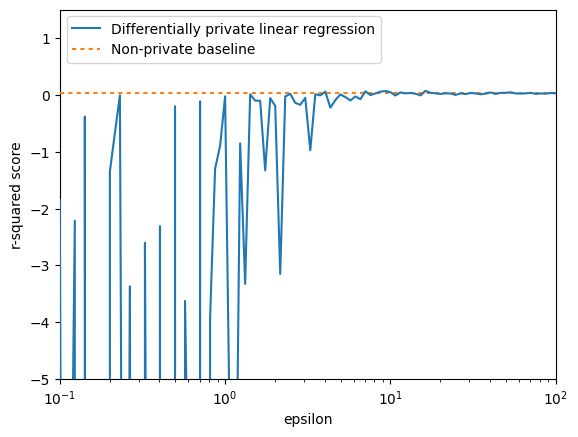

In [8]:
import matplotlib.pyplot as plt

plt.semilogx(epsilons, accuracy, label="Differentially private linear regression", zorder=10)
plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
plt.xlabel("epsilon")
plt.ylabel("r-squared score")
plt.ylim(-5, 1.5)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=2)

In [12]:
import numpy as np
from diffprivlib.models import LinearRegression

# Correcte vorm: bounds_X is een tuple van twee arrays (minima en maxima per feature)
bounds_X = (np.array([-0.11, -0.05]), np.array([0.12, 0.06]))
bounds_y = (25.0, 346.0)

dp_model = LinearRegression(epsilon=1.0, bounds_X=bounds_X, bounds_y=bounds_y)
dp_model.fit(X_train, y_train)
dp_r2 = dp_model.score(X_test, y_test)

print(f"Differentially private R² score: {dp_r2:.2f}")


Differentially private R² score: -0.06


Dat overzicht komt uit de statistische interpretatie van de R²-score, ook wel de coëfficiënt van determinatie genoemd. Het is een standaardmaat in regressiemodellen (zoals Linear Regression) en wordt breed gebruikt, o.a. in:

Scikit-learn documentatie over score() bij regressie
Statistiekboeken en machine learning-cursussen
Onderwijs en papers over model-evaluatie
Wat betekent de R²-score precies?
De R²-score meet hoeveel van de variantie in de targetvariabele (y) verklaard wordt door het model.

R² = 1.0 → perfecte voorspellingen, geen fout
R² = 0.0 → model voorspelt niet beter dan simpelweg het gemiddelde van y
R² < 0 → model doet het slechter dan het gemiddelde voorspellen
Dat laatste (negatieve R²) betekent dus dat het model zo slecht is, dat je letterlijk betere resultaten zou hebben door gewoon het gemiddelde van y te nemen.